In [1]:
import os
import torch
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from sklearn.model_selection import KFold

from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
)

from monai.config import print_config
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

from monai.data import (
    DataLoader,
    Dataset,
    decollate_batch,
)

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print_config()
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /u/home/s/<username>/miniconda3/envs/kaggle/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNK

In [2]:
torch.cuda.empty_cache()

In [3]:
os.chdir('/u/home/s/skikuchi/scratch/MedAI6/Unet')

In [4]:
data_dir = '/u/home/s/skikuchi/scratch/MedAI6/ai_contest2024'
organs = ['gallbladder','liver','pancreas','spleen','kidney_left','kidney_right','adrenal_gland_left','adrenal_gland_right','aolta','stomach','duodenum']

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii")))

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

sub_df = pd.read_csv('../ai_contest2024/sample_submission.csv')
print('num of train images: ',len(train_images),'\nnum of train labels: ',len(train_labels),'\nnum of test images: ',len(test_images))


print('data path\n',train_images[0],'\n',train_labels[0])
sub_df.head()

num of train images:  357 
num of train labels:  357 
num of test images:  600
data path
 /u/home/s/skikuchi/scratch/MedAI6/ai_contest2024/imagesTr/aicontest2024ver2_0002_0000.nii 
 /u/home/s/skikuchi/scratch/MedAI6/ai_contest2024/labelsTr/aicontest2024ver2_0002.nii


,id,prediction
0,0486_gallbladder,1 1
1,0486_liver,1 1
2,0486_pancreas,1 1
3,0486_spleen,1 1
4,0486_kidney_left,1 1


In [5]:
img = nib.load(train_images[0])
img = img.get_fdata()
label = nib.load(train_labels[0])
label = label.get_fdata()
print('image: ',img.shape, img.max(),img.min())
print('ground-truth: ',label.shape, label.max(),label.min())

image:  (255, 177, 440) 3013.0 -1190.0
ground-truth:  (255, 177, 440) 11.0 0.0


(-0.5, 254.5, 176.5, -0.5)

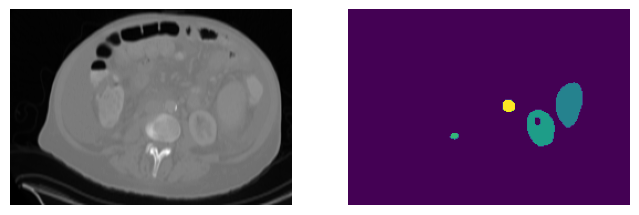

In [6]:
img_slice = np.fliplr(np.rot90(img[:,:,180]))
label_slice = np.fliplr(np.rot90(label[:,:,180]))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.imshow(img_slice, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(label_slice,)
plt.axis('off')

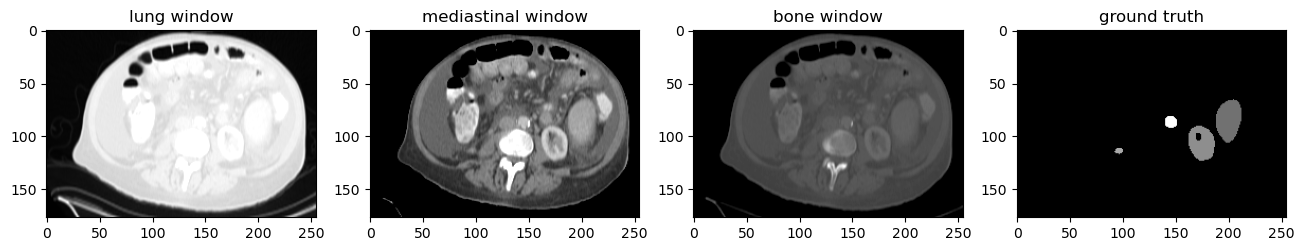

In [7]:
def apply_window(image, level, width):
    lower = level - (width / 2)
    upper = level + (width / 2)
    windowed_image = np.clip(image, lower, upper)
    return windowed_image

# 肺野条件、縦隔条件、骨条件に基づくウィンドウ設定
lung_window = apply_window(img_slice, -650, 1500)  # 肺野条件
mediastinal_window = apply_window(img_slice, 40, 400)  # 縦隔条件
bone_window = apply_window(img_slice, 400, 1800)  # 骨条件

# 画像を並べて表示
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(lung_window, cmap='gray')
plt.title('lung window')

plt.subplot(1, 4, 2)
plt.imshow(mediastinal_window, cmap='gray')
plt.title('mediastinal window')

plt.subplot(1, 4, 3)
plt.imshow(bone_window, cmap='gray')
plt.title('bone window')

plt.subplot(1, 4, 4)
plt.imshow(label_slice, cmap='gray')
plt.title('ground truth')

plt.show()

In [8]:
img = nib.load(train_images[0]).get_fdata()
img = img.get_fdata()
label = nib.load(train_labels[0])
label = label.get_fdata()

In [31]:
img_, label_ = A_transform(image=img, label=label)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
class ImageFolder(Dataset):
    def __init__(self, data_dict, transform=None, total_classes=None):
        self.transform = transform
        self.data = data_dict
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        _image, _label = self.data[index]
        img = nib.load(_image).get_fdata()
        lbl = nib.load(_label).get_fdata()
        #img, lblにはそれぞれ画像とラベルが格納されている
        if self.transform:
            img, lbl = self.transform(image=img, label=lbl)
        return img, lbl        

In [34]:
import albumentations as A
A_transform = A.Compose([
    A.Affine(scale={"x":(0.7, 1.3), "y":(0.7, 1.3)}, translate_percent={"x":(0, 0.1), "y":(0, 0.1)}, rotate=(-10, 10), shear=(-10, 10), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.2),
        A.MedianBlur(blur_limit=3, p=0.2),
    ], p=1.0),
    A.OneOf([
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, border_mode=1, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.1, border_mode=1, p=0.2)
    ], p=0.4),
    A.GaussNoise(var_limit=0.05, p=0.2),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
    RandSpatialCropd(keys=["image", "label"], roi_size=(128, 128, 128),random_size=False),
    
])

/u/home/s/skikuchi/miniconda3/envs/kaggle/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [42]:
from monai.transforms import (
    #以降で使ってるの全部書く
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
)

In [21]:
orig_train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
        RandSpatialCropd(keys=["image", "label"], roi_size=(128, 128, 128),random_size=False),

    ]
)
orig_val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [119]:
from torchvision.transforms import RandomAffine

In [43]:
train_transforms = Compose(
    [   LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(
        #    keys=["image", "label"],
        #    pixdim=(1.0, 1.0, 1.0),
        #    mode=("bilinear", "nearest"),
        #),
        RandAffined(keys=["image", "label"], mode=("bilinear", "nearest"),
            rotate_range=[np.pi / 8, np.pi / 8, np.pi / 8,],
            scale_range=0, prob=0.4, cache_grid = True,
            ),
        RandGaussianSmoothd(keys=["image"], prob=0.3, sigma_x=(0.5, 1.5), sigma_y=(0.5, 1.5), sigma_z=(0.5, 1.5)),
        RandGaussianNoised(keys=["image"], prob=0.3),
         
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
        RandSpatialCropd(keys=["image", "label"], roi_size=(128, 128, 128),random_size=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/u/home/s/skikuchi/miniconda3/envs/kaggle/lib/python3.10/site-packages/monai/transforms/spatial/array.py:2426: UserWarning: cache_grid=True is not compatible with the dynamic spatial_size, please specify 'spatial_size'.
  warnings.warn(
/u/home/s/skikuchi/miniconda3/envs/kaggle/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


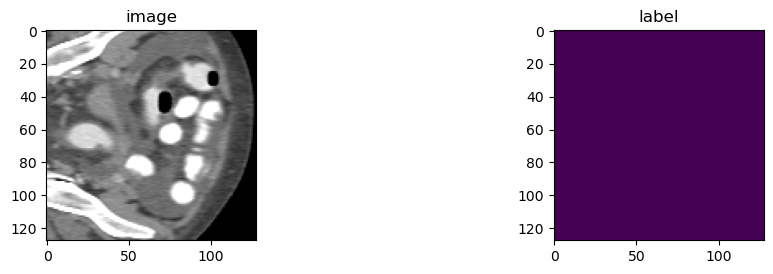

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


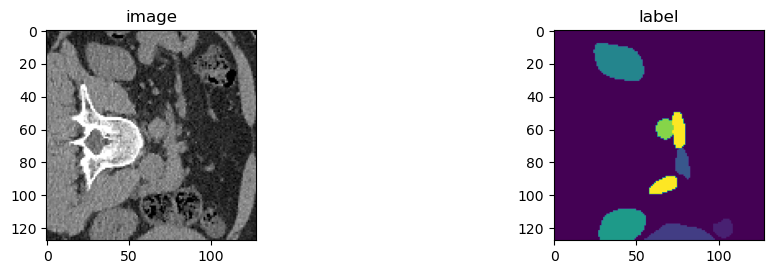

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


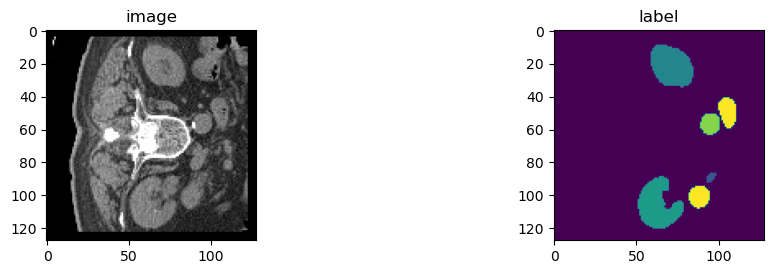

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


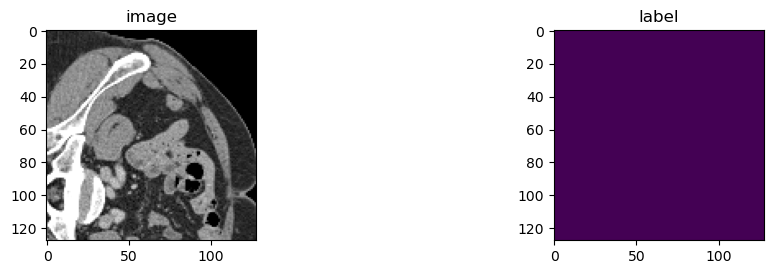

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


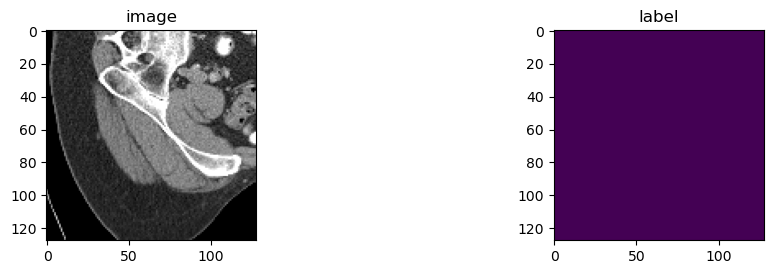

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


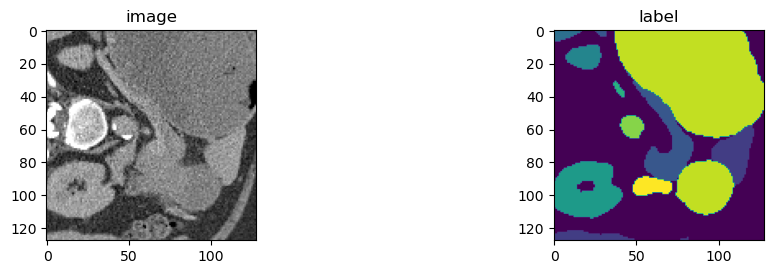

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


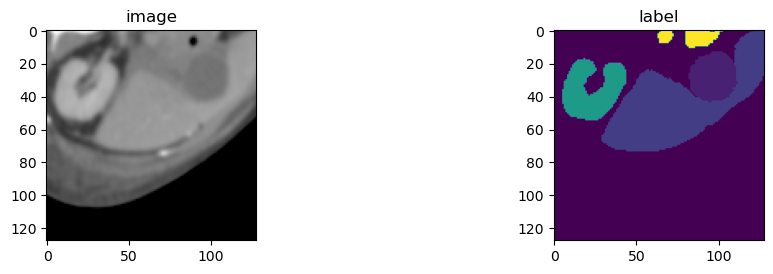

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


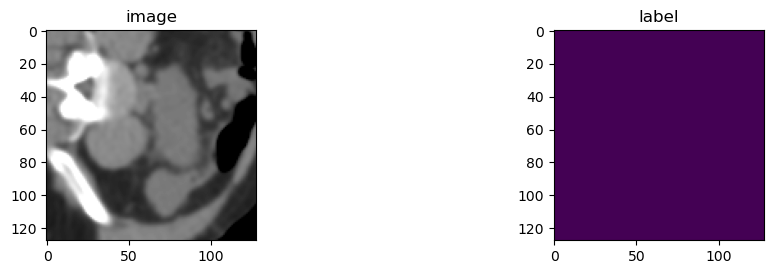

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


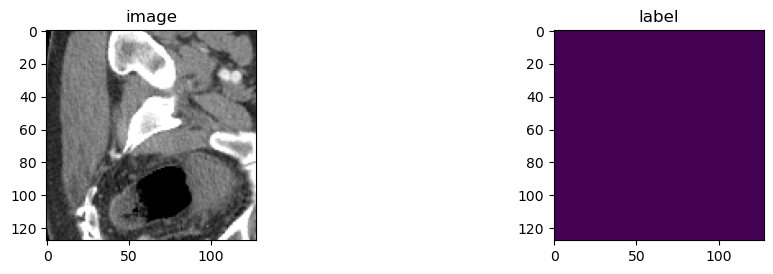

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([128, 128, 128])


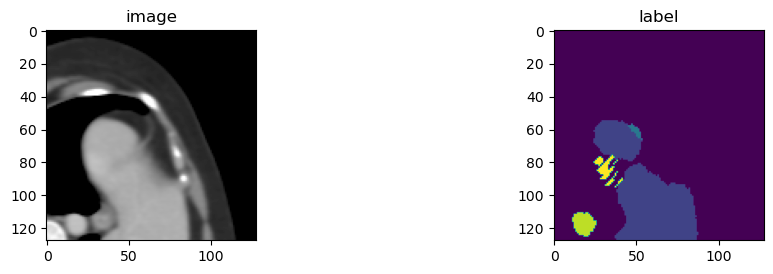

In [44]:
check_ds = Dataset(data=data_dicts, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, pin_memory=True, num_workers=2, shuffle=False)
count = 0
for check_data in check_loader:
    image, label = (check_data["image"][0][0], check_data["label"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(2, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, 80], cmap="gray")
    plt.subplot(2, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, 80])
    plt.show()
    count +=1
    if count==10: break

In [45]:
torch.manual_seed(2809)
check_ds = Dataset(data=data_dicts, transform=orig_train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, pin_memory=True, num_workers=2, shuffle=False)
count = 0
for check_data in check_loader:
    image, label = (check_data["image"][0][0], check_data["label"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(2, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, 80], cmap="gray")
    plt.subplot(2, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, 80])
    plt.show()
    count +=1
    if count==10: break

NameError: name 'orig_train_transforms' is not defined

In [107]:
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(data_dicts):
    train_files, val_files = np.array(data_dicts)[train_index], np.array(data_dicts)[val_index]
    break

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2,pin_memory=True)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1,pin_memory=True)

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=12,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#model.load_state_dict(torch.load("best_metric_model2.pth"))

loss_function = DiceCELoss(to_onehot_y=True, softmax=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scaler = torch.cuda.amp.GradScaler()
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [108]:
pd.read_csv('/u/home/s/skikuchi/scratch/MedAI6/submission.csv')

,id,prediction
0,0001_gallbladder,7029568 1 7029781 1 7029992 1 7029994 1 706961...
1,0001_liver,4237848 1 4238061 1 4277466 1 4277678 2 427789...
2,0001_pancreas,2659068 1 2659281 2 2659492 3 2659705 3 265991...
3,0001_spleen,1538044 2 1538257 2 1538471 1 1577449 4 157766...
4,0001_kidney_left,2495030 4 2495241 7 2495453 8 2495665 9 249587...
...,...,...
6595,1105_adrenal_gland_left,4280591 1 4318551 1 4318680 2 4318809 3 431893...
6596,1105_adrenal_gland_right,6414799 3 6414928 4 6415059 3 6452888 6 645301...
6597,1105_aorta,4929744 5 4929874 7 4930006 5 4930136 6 493026...
6598,1105_stomach,3942615 1 3942745 1 3942875 1 3980444 3 398057...


In [109]:
max_epochs = 25
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=12)])
post_label = Compose([AsDiscrete(to_onehot=12)])

            
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()        
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            print(metric)
            metric_values.append(metric)
            if (metric > best_metric) and (epoch > 4):
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "sample_best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/25
1/71, train_loss: 3.7685


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

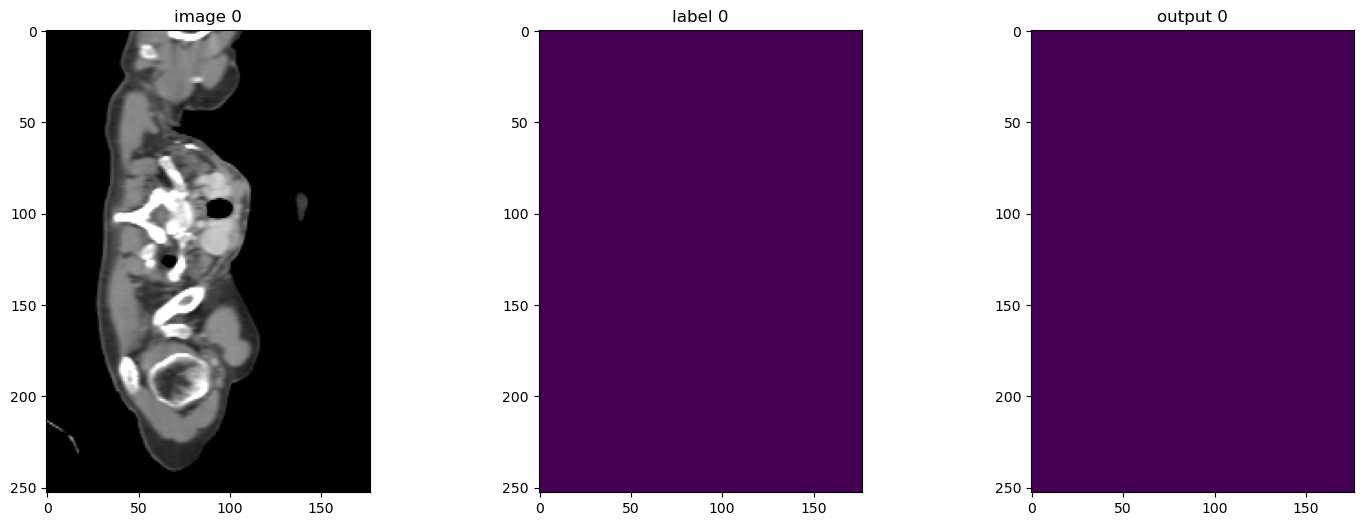

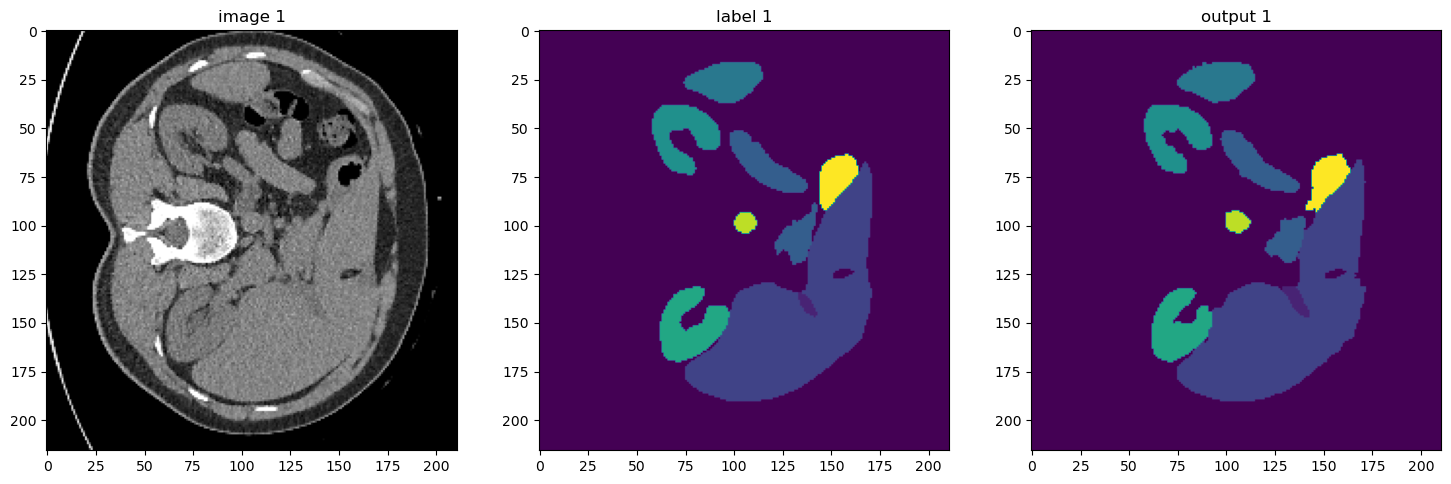

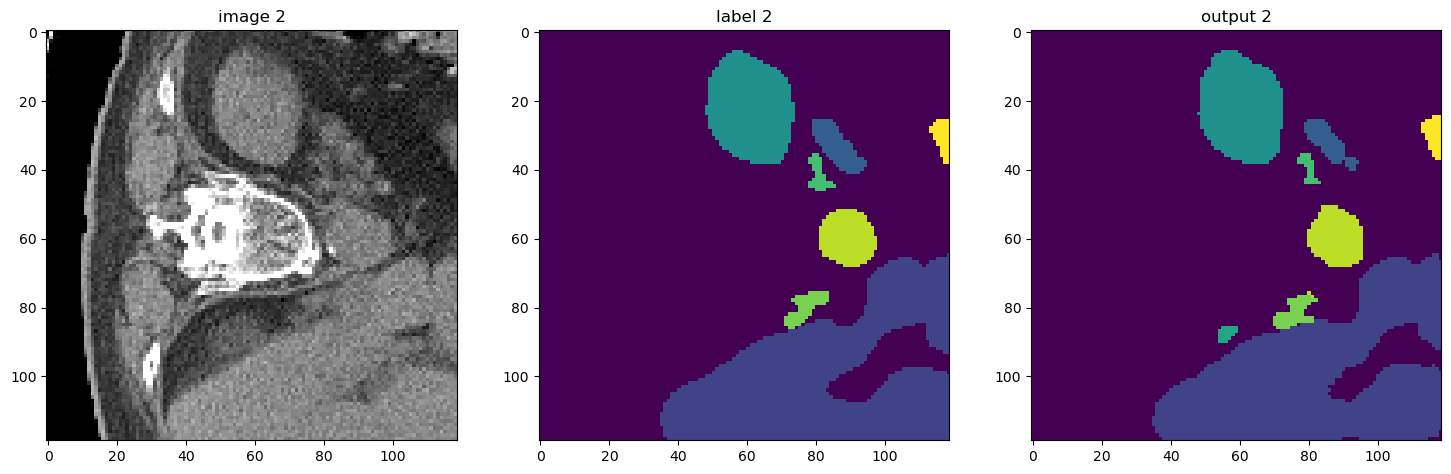

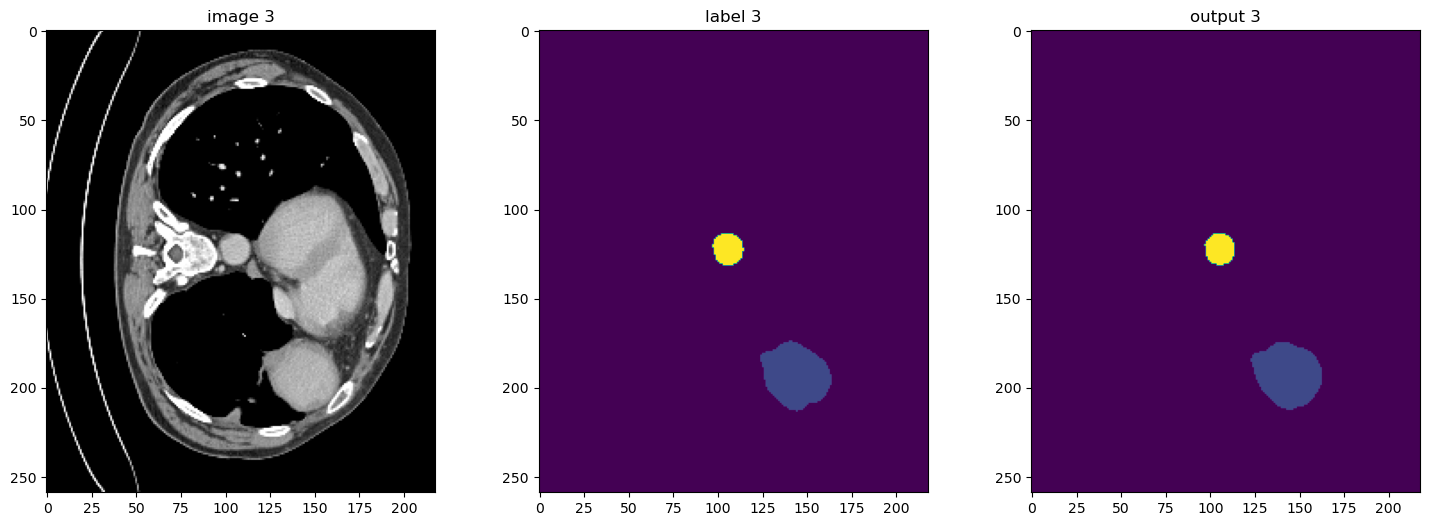

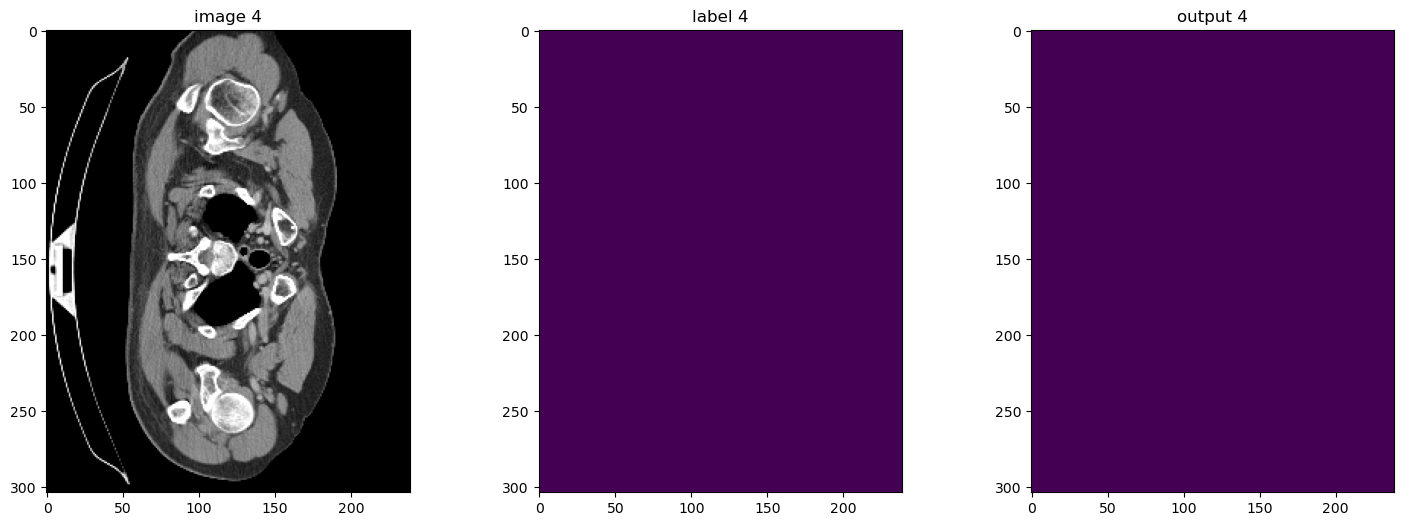

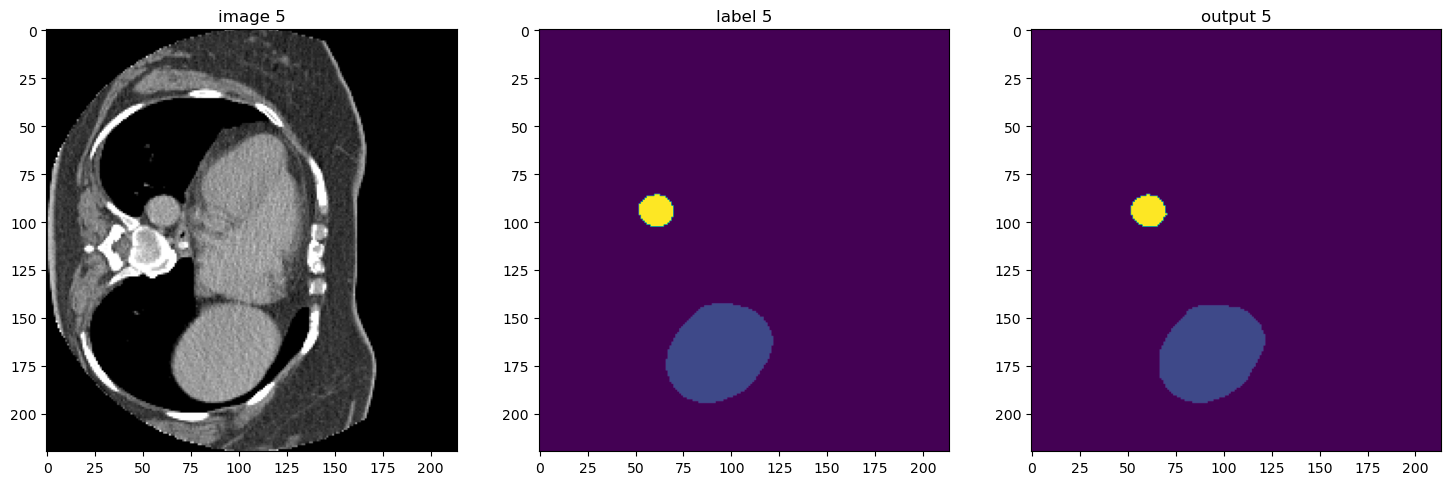

In [12]:
model.load_state_dict(torch.load("best_metric_model2.pth"))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, -20], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, -20])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, -20])
        plt.show()
        if i == 5:
            break

In [46]:
import gc

del train_ds, val_ds
del train_loader, val_loader

# ガーベージコレクションの実行
gc.collect()

NameError: name 'train_ds' is not defined

In [14]:
class_names ={1: 'gallbladder', 2: 'liver', 3: 'pancreas', 4: 'spleen',5:'kidney_left',6:'kidney_right',7:'adrenal_gland_left',8:'adrenal_gland_right',9:'aorta',10:'stomach',11:'duodenum'}
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def encode_rle_multiclass(img_data):
    # 画像データ内のユニークなクラスを取得し、バックグラウンドクラスを除外
    rle_results = {cls: "1 1" for cls in class_names.keys()}
    classes = np.unique(img_data)
    # 各クラスに対するRLE結果を計算
    for cls in classes:
        if cls == 0:  # バックグラウンドクラスをスキップ
            continue
        class_component = (img_data == cls).astype(np.float32)
        rle_encoded = rle_encode(class_component)
        rle_results[cls] = rle_encoded

    return [(class_names[cls], rle_results[cls]) for cls in class_names.keys()]

In [15]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii")))
test_ids = [path.split('_')[-2] for path in test_images]##　idを取得する。
test_data = [{"image": image, "id": ID} for image,ID in zip(test_images,test_ids)]
post_pred = Compose([AsDiscrete(argmax=True,keepdim=False)])

submission_df = pd.DataFrame()

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
    ]
)

test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

model.load_state_dict(torch.load("best_metric_model2.pth"))##上のセルで学習したモデルを読み込むときは、パスを"best_metric_model.pth"に変更してください。
model.eval()

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs = test_data["image"].to(device)
        file_id = str(test_data["id"][0])
        roi_size = (128, 128, 128)
        sw_batch_size = 16
        with torch.cuda.amp.autocast():
            test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]

        for j, output in enumerate(test_outputs):
            # 予測をNumpy配列に変換
            output_np = output.cpu().numpy()
            #print(output_np.shape)
            # RLEエンコーディングとデータフレームへの追加
            rle_encoded_data = encode_rle_multiclass(output_np)
            for cls_name, rle in rle_encoded_data:
                # ここでの 'file_id' は適切なファイル識別子に置き換える
                submission_df = pd.concat([submission_df,pd.DataFrame([f'{file_id}_{cls_name}', rle]).T], ignore_index=True)

submission_df.columns=['id', 'prediction']
# CSVファイルに保存
submission_df.to_csv('submission.csv', index=False)

  0% 0/600 [00:00<?, ?it/s]

100% 600/600 [27:27<00:00,  2.75s/it]
